# Iterative Backtesting

This implementation helps testing and optimizing SMA strategy with historical binance data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import sys
from itertools import product
from lib.TechnicalIndicators import *

2023-05-19 23:25:17.248951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 23:25:18.375963: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-19 23:25:18.376032: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-19 23:25:18.580579: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-19 23:25:21.890692: W tensorflow/stream_executor/platform/default

### Maintenance Margin
The calculation of maintenance margin is necessary to get the liquidation price of orders.
This class keeps tables of maintenance margin of pairs of instruments. Your need to instantiate it before making orders. If you want to trade a new pair, you need to search its table and add it to the class!!!!

Tables and formula obtained from https://www.binance.com/en/futures/trading-rules/perpetual/leverage-margin

In [2]:
class MaintenanceMarginTables():
    #obtained from https://www.binance.com/en/futures/trading-rules/perpetual/leverage-margin
    
    def __init__(self):
        ### Available Maintenance Margin tables ###
        self.BTCUSDT = None
        self.BTCBUSD = None
        ########### Fill each table ##############
        d = {'Tier': range(1,11),
         'PB' : [50000, 250000, 1000000, 10000000, 20000000, 50000000, 100000000, 200000000, 300000000, 500000000], #Position Bracker (Notional Value in USDT) (top boundary)
         'ML' : [125, 100, 50, 20, 10, 5, 4, 3, 2, 1], #Max Leverage
         'MMR' : [0.004, 0.005, 0.01, 0.025, 0.05, 0.1, 0.125, 0.15, 0.25, 0.5], #Maintenance Margin Rate
         'MA' : [0, 50, 1300, 16300, 266300, 1266300, 2516300, 5016300, 25016300, 100016300] #Maintenance AMount (USDT)
        }
        self.BTCUSDT = pd.DataFrame(data = d)

        d = {'Tier': range(1,11),
         'PB' : [50000, 250000, 1000000, 7500000, 40000000, 100000000, 200000000, 400000000, 600000000, 1000000000], #Position Bracker (Notional Value in BUSD) (top boundary)
         'ML' : [50, 25, 20, 10, 6, 5, 4, 3, 2, 1], #Max Leverage
         'MMR' : [0.004, 0.005, 0.01, 0.025, 0.05, 0.1, 0.125, 0.15, 0.25, 0.5], #Maintenance Margin Rate
         'MA' : [0, 50, 1300, 16300, 203800, 2203800, 4703800, 9703800, 49703800, 199703800] #Maintenance AMount (BUSD)
        }
        self.BTCBUSD = pd.DataFrame(data = d)
        
    def get_table(self, pair):
        table = "self."+ pair.upper()
        return eval(table)
MMT = MaintenanceMarginTables()  

#stores minimum order quantities
class MinOrders():
    
    def __init__(self):
        self.BTCBUSD = 0.001
        self.BTCUSDT = 0.001 #0.001 BTC
    def get_min_units(self, pair):
        return eval("self." + pair)
MO = MinOrders()

In [3]:
#this is an example of how to retrieve a table and the necessary row with the information.
table = MMT.get_table("BTCBUSD") #get the table 
size = 60658 #size of position (amount bought)
#locate the corresponding row with size
row = table.loc[ size >= table['PB'].shift(1).fillna(0) ].loc[ size < table['PB'] ]
#get all the row values, these are the required to calculate maintenance margin.
tier, pb, ml, mmr, ma = row.values[0]
ma

50.0

In [4]:
#to calculate maintenance margin you should follow the formula:
#Maintenance Margin = Notional Position Value * Maintenance Margin Rate - Maintenance Amount
#Note: notional position value quantity of asset * current mark price =  current size of position
#we use just price instead of mark price for simplicity!!      
mm = size * mmr - ma
mm #maintenance margin

253.29000000000002

In [5]:
# Max leverage depends on how much we want to buy, so be careful!!!
#This is how we calculate the max leverage for a certain total amount that we want to buy
table = MMT.get_table("BTCUSDT") #get the table 
total_amount = 60658 #size of position (amount bought)
max_leverage = table.loc[ total_amount <= table['PB']].ML.iloc[0]
max_leverage

100

### How open position units (buy or sell) are calculated?

When you have leverage, you just want to spend the corresponding fraction of the ammount passed to function. For example, if you have leverage of 3 and you pass amount = 3000, then you just want to spend 1000 for buying or selling. With this in mind we build the next formulas that must hold true...

$$myAmount=TotalAmount/ Leverage$$

$$AmountForUnits + paidFee = myAmount$$

$$paidFee = (totalAmountBought)*Fee = (AmountForUnits*Leverage)*Fee$$

then, 

$$AmountForUnits + AmountForUnits*Leverage*fee = myAmount$$

$$AmountForUnits = myAmount/( 1 + Leverage*fee )$$

With this, you will spend your corresponding fraction of the money buying the correct units and paying the fee entirely.

Important:
 
$$AmountForUnits*Leverage + fee != myAmount*Leverage$$

In other words, you dont use all the amount you pass to the function to buy or sell units, because you have to pay fees with that money. The money you pay for fees increases with leverage. 


### How open position units (buy or sell) are calculated? New implementation

Binance has a minimum quantity of asset to buy, and you just can buy multiples of it... So for example, with the pair BTC/USDT, the min BTC you can buy is 0.001 BTC, also you just can buy multiples of that... (0.002, 0.003, etc.)

In order to buy that exact quantity, the comissions of opening a position will be calculated using the quantity to buy as a base. In other words

$$Costs = TotalUnits/Leverage + paidFee$$

$$paidFee = (TotalUnits)*Fee$$

### How close position units (buy or sell) are calculated?

When you close a position, you also have to consider leverage, because when do it, it returns to you your units on "amount" and the profit of ALL the position. In other words, you have to return the units to the broker again. Dont forget to pay the comission of closing. We use the next formulas to calculate everything: 

$$Units = UnleveredUnits*Leverage$$
$$myAssetEntryValue = unleveredUnits * entryPrice$$
$$profit = Units * (currentPrice - entryPrice)$$
$$payFee = abs(Units) * currentPrice * Fee$$ 

Then you consider all this to update your current balance:

$$balance += myAssetEntryValue + profit - payFee$$

Important: for short positions, units are negative, because you sell them, then the formulas have sense.

# Order Class

This class keeps track of each order calculations

In [6]:
class Order():
    
    def __repr__(self):
        if self.position == 1:
            return "LONG"
        else:
            return "SHORT"
    
    def __init__(self, amount, leverage, expected_entry_price, position, created_at, 
                 fee_maker, fee_taker, use_fee, symbol, order_type = "MARKET", verbose = True):
        self.verbose = verbose
        self.symbol = symbol
        self.order_type = order_type
        self.amount = amount #desired size of position (leverage included)
        self.leverage = leverage
        self.expected_entry_price = expected_entry_price
        self.position = position #long (1) or short (-1)
        self.fee_maker = fee_maker #comision for limit order
        self.fee_taker= fee_taker #comision for market order
        self.use_fee = use_fee #True or False
        self.created_at = created_at # creating position datetime
        self.min_units = self.get_min_units()
        ########### Open position params ###########
        self.entry_price = None
        self.my_invest = None #amount to really spend from my balance
        self.opening_at = None #opening position datetime
        self.my_pos_amount = None #unlev amount to buy units (spent with no fee)
        self.my_pos_units = None #unit version of above attr
        self.pos_amount = None #position size (includes leverage)
        self.units = None #unit version of above attr
        self.opening_fee_as_amount = None 
        self.opening_fee_as_units = None
        self.blocks = 0 #stores the int number of times that min units can be bought
        self.available = 1 #currently all position is open
        ########### Close position params ###########
        self.closing_at = [] #close position datetime
        self.closing_fee_as_amount = [] 
        self.closing_fee_as_units = []
        self.closing_price = []
        self.liquidated = False #Tells if position was liquidated
        self.liquidation_price = None #stores the single liq price of order, if order is liquidated, to get real one, use closing_price[-1]
        
    def get_entry_price(self, low , high):
        if self.entry_price is not None:
            return self.entry_price
        #open price is a random number of current candle
        if self.order_type == "MARKET": 
            self.entry_price = np.random.uniform(low=low, high=high)
            #open price will be the expected...
        else:
            self.entry_price = self.expected_entry_price
        return self.entry_price
    
    def get_close_price(self, low, high, close, order_type = "MARKET"):
        if order_type == "MARKET": 
            close_price = np.random.uniform(low=low, high=high)
            #open price will be the expected...
        else:
            close_price = close
        return close_price
        
    def open_position(self, date, low, high):
        ##################### Works for long and short ################## 
        self.opening_at = date # open position datetime
        self.entry_price = self.get_entry_price(low, high)
        min_amount_with_fee = self.get_min_amount_to_spend(self.entry_price, include_fee = True, include_lev = False)
        self.blocks = self.amount // min_amount_with_fee #times min amount can be bought
        self.my_invest = self.get_min_amount_to_spend(self.entry_price, include_fee = True, include_lev = True) * self.blocks
        min_amount = self.get_min_amount_to_spend(self.entry_price, include_fee = False, include_lev = False)
        self.pos_amount = min_amount * self.blocks
        self.units = self.pos_amount / self.entry_price
        self.my_pos_amount = self.pos_amount / self.leverage
        self.my_pos_units = self.my_pos_amount / self.entry_price
        self.opening_fee_as_amount = (min_amount_with_fee - min_amount) * self.blocks
        self.opening_fee_as_units = self.opening_fee_as_amount/self.entry_price
        if self.blocks == 0: 
            print("Insufficient Margin to buy units")
            return False   
        if self.position == 1 and self.verbose:
            print("{} |  Buying {} for {}, leverage {}".format(self.opening_at, round(self.units, 5), round(self.entry_price, 4), self.leverage))
        elif self.verbose:
            print("{} |  Selling {} for {}, leverage {}".format(self.opening_at, round(self.units, 5), round(self.entry_price, 4), self.leverage))
        return True
        
    def get_close_fee(self, price, as_amount= True, prc = 100, use_available = True):
        #long - pay more comission if price raises
        #short - pay more comission if price falls
        if use_available:
            fraction = self.available * ( prc/100 )
        else: #if false, use all initial position budget
            fraction = ( prc/100 )
        fee = self.units * self.entry_price + self.position * self.units * (price - self.entry_price) 
        fee = fee * fraction * self.fee_taker #consider fee used and percentage of position to close
        if not as_amount: fee/=price #as units
        return fee * self.use_fee
    
    def get_PnL(self, price, include_fee = False, as_amount = True, prc = 100, use_available = True):
        #get profit (by default doesnt include fee as Binance)
        if use_available:
            fraction = self.available * ( prc/100 )
        else: #if false, use all initial position budget
            fraction = ( prc/100 )
        PnL = self.position * self.units * (price - self.entry_price) * fraction
        fee = self.get_close_fee(price, as_amount= True, prc = prc, use_available = use_available) * include_fee
        profit = PnL - fee
        if not as_amount: profit/=price
        return profit
    
    def get_current_amount(self, lev = True):
        if lev:
            return (self.pos_amount)*self.available
        else:
            return (self.my_pos_amount)*self.available
    
    def get_position_value(self, price, include_fee = True, as_amount = True, prc = 100, use_available = True):
        if use_available:
            fraction = self.available * ( prc/100 )
        else: #if false, use all initial position budget
            fraction = ( prc/100 )
        #gets the spent money and profits of the position (subtracts closing fee if True)
        profit = self.get_PnL(price = price, include_fee = include_fee, as_amount = True, prc = prc, use_available = use_available)
        pos_val = self.my_pos_amount * fraction  + profit
        if not as_amount: pos_val /= price
        return pos_val
    
    def close_position(self, date, price, prc = 100):
        fraction = self.available * (prc / 100)
        #if after closing with prc the remaining is less than min position, better close all now
        if self.units *(self.available - fraction) < self.min_units:
            prc = 100
            fraction = self.available
        #if closing is less than min units, close minimum units
        elif self.units * fraction < self.min_units:
            prc = (self.min_units / (self.units * self.available))*100
            fraction = self.available * (prc / 100)
        #close always a multiple of min units
        else:
            blocks_to_sell = round(self.blocks * fraction, 0)
            fraction = blocks_to_sell / self.blocks
            prc = fraction / self.available * 100 
        self.closing_at.append( date )
        self.closing_price.append( price )
        self.closing_fee_as_amount.append( self.get_close_fee(price, as_amount = True, prc = prc, use_available = True) )
        self.closing_fee_as_units.append( self.get_close_fee(price, as_amount = False, prc = prc, use_available = True) )
        pos_value = self.get_position_value(price, prc = prc, use_available = True)
        self.available = self.available - fraction #stores the position still opened
        partially = " partially" if self.is_open() else ""
        if self.position == -1 and self.verbose:
            print("{} |  Buying (closing{}) {} for {}".format(date, partially, self.units*fraction, round(price, 6)))
        elif self.verbose:
            print("{} |  Selling (closing{}) {} for {}".format(date, partially, self.units*fraction, round(price, 6)))  
        return pos_value
    
    def is_open(self):
        return abs(self.available) > 1e-12
    
    def is_closed(self):
        return not self.is_open()
    
    def get_maintenance_margin(self, price):
        #this is an example of how to retrieve a table and the necessary row with the information.
        if self.symbol.upper() in "BTCUSDT":
            table = MMT.get_table("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            table = MMT.get_table("BTCBUSD")
        else:
            table = MMT.get_table(self.symbol)
        size = self.units*price #size of position
        #locate the corresponding row with size
        row = table.loc[ size >= table['PB'].shift(1).fillna(0) ].loc[ size < table['PB'] ]
        #get all the row values, these are the required to calculate maintenance margin.
        tier, pb, ml, mmr, ma = row.values[0]
        mm = size * mmr - ma
        return mm
    
    def get_min_units(self):
        #get minimum units to buy (doesnt include fee)
        if self.symbol.upper() in "BTCUSDT":
            minimum = MO.get_min_units("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            minimum = MO.get_min_units("BTCBUSD")
        else:
            minimum = MO.get_min_units(self.symbol)
        return minimum
    
    def get_min_amount_to_spend(self, price, include_fee = True, include_lev = False):
        #this function returns the minimum amount to spend (includes fee).
        #get my invest in the position    
        pos_amount = self.min_units * price
        spent = pos_amount
        if include_lev: spent = pos_amount / self.leverage
        if not include_fee: return spent
        #include fees of position
        if self.order_type == "MARKET":
            spent += self.use_fee * self.fee_maker * pos_amount 
        else:
            spent += self.use_fee * self.fee_taker * pos_amount 
        return spent
    
    def calculate_margin_ratio(self, price):
        #when margin ratio == 1, that is the liquidation price
        maintenance_margin = self.get_maintenance_margin(price)
        balance = self.my_pos_amount #just for isolated mode (for cross you must use wallet)
        quantity = self.units
        mark_price = price #for simplicity
        entry_price = self.entry_price
        
        margin_ratio = maintenance_margin/( balance + self.position* quantity * ( mark_price - entry_price ))
        return margin_ratio
    
    def get_liquidation_price(self):
        #uses price instead of mark_price for simplicity
        #the liquidation price changes to farther when mark price gets close, so we  
        #execute this function many times to get close to the real one!!!!
        if self.liquidation_price is not None: return self.liquidation_price
        mark_price = self.entry_price
        pos = self.position
        entry_price = self.entry_price
        balance = self.my_pos_amount #just for isolated mode (for cross you must use wallet)
        quantity = self.units
        precision = 5 #more precision == closer you get to real liquidation price
        for i in range(precision):
            maintenance_margin = self.get_maintenance_margin(mark_price)
            liquidation_price = pos*( maintenance_margin - balance )/quantity + entry_price
            mark_price = liquidation_price
        self.liquidation_price = liquidation_price 
        return self.liquidation_price
    
    def should_liquidate(self, price): 
        if self.position == 1 and price <= self.get_liquidation_price():
            return True
        elif self.position == -1 and price >= self.get_liquidation_price():
            return True
        else:
            return False
    
    def liquidate_position(self, date, global_liquidation = None):
        liq_price = self.liquidation_price
        # if this is given, you have multiple orders and other liquidation price
        if global_liquidation != None:
            liq_price = global_liquidation
        self.closing_at.append( date )
        self.closing_price.append( liq_price )
        self.liquidated = True
        if self.position == -1 and self.verbose:
            print("{} |  Buying (liquidating) {} for {}".format(date, self.units*self.available, round(self.closing_price[-1], 5)))
        elif self.verbose:
            print("{} |  Selling (liquidating) {} for {}".format(date, self.units*self.available, round(self.closing_price[-1], 5))) 
        self.available = 0
        

## How to use orders

In [48]:
#initialize the order
from datetime import datetime

leverage = 2
#initialize the order (it makes sense with limit orders because its like submit them)
order = Order(amount = 21, #more info of this on sections above
              leverage = leverage, 
              expected_entry_price = 20000, #useful for limit orders, price when order is executed 
              position = 1, #1 for long, -1 for short
              created_at = datetime.now(), #datetime when order is created        
              fee_maker = 0.0002, 
              fee_taker = 0.0004, 
              use_fee = True,
              symbol = "BTCUSD",
             order_type = "MARKET")
#execute the order 
#with market orders we use low and high of candles to grab a random number

order.open_position(datetime.now(), low = order.expected_entry_price, high = order.expected_entry_price)

2023-04-04 09:06:35.873982 |  Buying 0.001 for 20000.0, leverage 2


True

In [49]:
#order.get_min_amount_to_spend(10000, include_fee=True, include_lev = True)

In [50]:
#get my amount spend on position (not including fee)
order.my_pos_amount

10.0

In [51]:
#get opening fee of position
order.opening_fee_as_amount

0.004000000000001336

In [52]:
#get my spent money in the order, its the sum of the two above
order.my_invest

10.004

In [53]:
#get closing fee of position at a certain price
order.get_close_fee(price = 50522, as_amount = True)

0.020208800000000002

In [54]:
#prints current PnL of position at a certain price
order.get_PnL(price = 40000, as_amount = True, include_fee = True)

19.984

In [47]:
#returns all money that you will receive if position is closed (including invested one) at a certain price
order.get_position_value(price = 40000, as_amount = True, include_fee = True)

39.984

In [16]:
#True if position is open
order.is_open()

True

In [17]:
#closes the position and returns profits at a certain price...
pos_val = order.close_position(datetime.now(), price = 40000)
pos_val

2023-04-04 08:37:27.804729 |  Selling (closing) 0.001 for 40000


39.984

In [18]:
#True if position is closed
order.is_closed()

True

### Close orders partially

In [55]:
#initialize the order
from datetime import datetime

leverage = 2
#initialize the order (it makes sense with limit orders because its like submit them)
order = Order(amount = 41, #more info of this on sections above
              leverage = leverage, 
              expected_entry_price = 20000, #useful for limit orders, price when order is executed 
              position = 1, #1 for long, -1 for short
              created_at = datetime.now(), #datetime when order is created        
              fee_maker = 0.0002, 
              fee_taker = 0.0004, 
              use_fee = True,
              symbol = "BTCUSD")
#execute the order 
order.open_position(datetime.now(), low = order.expected_entry_price, high = order.expected_entry_price)

2023-04-04 09:07:49.773742 |  Buying 0.002 for 20000.0, leverage 2


True

In [26]:
#prints current PnL of position at a certain price
#order.get_PnL(price = 50000, as_amount = True, include_fee = True)

In [27]:
#returns all money that you will receive if position is closed (including invested one) at a certain price
#order.get_position_value(price = 50000, as_amount = True, include_fee = True)

In [56]:
#close a percentage of the position
order.close_position(datetime.now(), price = 50000, prc = 50)

2023-04-04 09:08:01.996906 |  Selling (closing partially) 0.001 for 50000


39.980000000000004

In [57]:
#True if order is open
order.is_open()

True

In [58]:
#close the remaining position
order.close_position(datetime.now(), price = 51000, prc = 10)

2023-04-04 09:08:35.686569 |  Selling (closing) 0.001 for 51000


40.979600000000005

In [59]:
order.is_open()

False

¡¡This is useful for test with binance!!

In [29]:
#initialize the order
from datetime import datetime

leverage = 50
#initialize the order (it makes sense with limit orders because its like submit them)
order = Order(amount = 995.7, #more info of this on sections above
              leverage = leverage, 
              expected_entry_price = 16875, #useful for limit orders, price when order is executed 
              position = -1, #1 for long, -1 for short
              created_at = datetime.now(), #datetime when order is created        
              fee_maker = 0.0002, 
              fee_taker = 0.0004, 
              use_fee = True,
              symbol = "BTCUSD")
#execute the order 
order.open_position(datetime.now(),low = order.expected_entry_price, high = order.expected_entry_price)

2023-01-09 00:03:40.241959 |  Selling 0.057847494553376906 for 16875.0, leverage 50


True

In [30]:
order.opening_fee_as_amount

0.3904705882352941

In [31]:
close_price = 16934
order.get_close_fee(price = close_price, as_amount = True)

0.38910538736383443

In [32]:
order.get_PnL(price = close_price, as_amount = True, include_fee = False)

-3.4130021786492373

In [33]:
profit = order.get_PnL(price = close_price, as_amount = True, include_fee = False) - order.opening_fee_as_amount- order.get_close_fee(price = close_price, as_amount = True)
profit

-4.192578154248365

In [34]:
2242.73 + profit

2238.537421845752

In [35]:
order.close_position(datetime.now(), close_price)

2023-01-09 00:03:44.351910 |  Buying (closing) 0.057847494553376906 for 16934


15.721421845751633

In [36]:
order.my_pos_amount

19.914

### Calculating liquidation price of an order
This example can give same results as lecture:

https://www.udemy.com/course/cryptocurrency-algorithmic-trading-with-python-and-binance/learn/lecture/29496642?start=660#overview

If you want to reproduce the results of lecture, you have to hardcode balance to given on lecture on functions

The formulas of liquidation price also can be found there.

In [64]:
#initialize the order
from datetime import datetime

leverage = 50
#initialize the order (it makes sense with limit orders because its like submit them)
order = Order(amount = 83.38, #more info of this on sections above
              leverage = leverage, 
              expected_entry_price = 16675.50, #useful for limit orders, price when order is executed 
              position = 1, #1 for long, -1 for short
              created_at = datetime.now(), #datetime when order is created        
              fee_maker = 0.0002, 
              fee_taker = 0.0004, 
              use_fee = False,
              symbol = "BTCUSD")
#execute the order 
order.open_position(datetime.now(), low = order.expected_entry_price, high = order.expected_entry_price)

2023-04-04 09:11:46.609988 |  Buying 0.005 for 16675.5, leverage 50


True

In [65]:
#use to retrieve the liquidation price of the order!!!
liq_price = order.get_liquidation_price()
liq_price

16407.620481927985

In [61]:
#you can verify if is the liquidation price if margin ratio is close to 1 for that number
order.calculate_margin_ratio(liq_price) 

0.9999999997470597

In [62]:
#Returns true or false, tells just if should liquidate
order.should_liquidate(liq_price)

True

In [63]:
#PnL is not -100% on liquidation price, because binance liquidates before reaching the deadline.
#Thats why is recommended to do a Stop Loss near liquidation price. You can save a lot of money doing that.
order.get_PnL(price = 16003.7, as_amount = True, include_fee = False)

-3.3589999999999964

In [64]:
#liquidate a position at a certain time, it closes the position and mark it as liquidated
order.liquidate_position(date = datetime.now())

2023-04-02 20:48:52.149952 |  Selling (liquidating) 0.005 for 8371.23494


In [67]:
#entry: 16,675.50
#liq (binance): 16,069.57
#liq (3.35 more): 15,396.88
#entry - liq = 605.93
#liq - liq(3.35 more) = 672.69
order.get_PnL(price = 16072.77, as_amount = True, include_fee = True) - order.opening_fee_as_amount

-0.0

# BinanceApi Class
This class helps to keep track of actions made in "account".

In [66]:
class BinanceApi():

    def __init__(self, symbol, start, end, amount, use_fee = True, fee_maker=0, fee_taker=0,
                 verbose = True, csv = "data/5m.csv"):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.csv = csv #csv to use
        self.initial_balance = amount
        self.available_balance = amount #keeps unlevered balance (real balance)
        self.open_orders = [] #stores open orders
        self.closed_orders= [] #stores closed orders
        self.PnLs = []
        self.liquidated_orders = 0 #stores count of liquidated orders
        self.trades = 0
        self.paid_fees = 0 #accumulates paid fees
        self.use_fee = use_fee
        self.fee_maker = fee_maker #limit orders fee
        self.fee_taker = fee_taker #market orders fee (higher)
        self.leverage = 1
        self.get_data()
        self.verbose = verbose
        self.global_liquidation = None #stores liquidation price of all positions combined
    def get_data(self):
        raw = pd.read_csv(self.csv, parse_dates = ["Date"], index_col = "Date").dropna()
        raw = raw.loc[self.start:self.end]
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        raw["Hold Strategy"] = raw["returns"].cumsum().apply(np.exp) * self.initial_balance
        self.data = raw

    def plot_data(self, cols = None, show_pos = False):
        if not show_pos:
            if cols is None:
                cols = "Close"
            self.data[cols].plot(figsize = (12, 8), title = self.symbol)
        else:
            colors = ['green' if x==1 else ( "red" if x== -1 else "gray" ) for x in self.positions]
            plt.figure(figsize=(10,6))
            for i in range(1,len(self.data)):
                s = self.data.iloc[i-1:i+1]
                plt.plot(s.index, s[["NAV"]], c=colors[i-1], linewidth = 1)
            plt.plot(self.data.index, self.data[["Hold Strategy"]], c="cornflowerblue", linewidth=1)    
            plt.show()
    def get_values(self, bar):
        date = str(self.data.index[bar])
        close = round(self.data.Close.iloc[bar], 5)
        return date, close
    
    def get_value(self, bar, column):
        value = round(self.data[column].iloc[bar], 5)
        return value
    def print_available_balance(self, bar):
        date, price = self.get_values(bar)
        print("{} | Current Balance: {}".format(date, round(self.available_balance, 2)))
        
    def submit_order(self, bar, amount = None, pos = "BUY", order_type = "LIMIT"):
        #close positions if necessary
        if (self.get_position() in [-1] and pos == "BUY") or (self.get_position() in [1] and pos == "SELL"):
            close_amount = min(self.current_invested_amount(), amount)
            self.close_position(bar, close_amount, order_type = order_type)
            amount = amount - close_amount
        #open position...
        if abs(amount) > 1e-04:
            date, expected_entry_price = self.get_values(bar)
            
            order = Order(amount = amount, 
              leverage = self.leverage, 
              expected_entry_price = expected_entry_price,
              position = 1 if pos == "BUY" else -1, 
              created_at = date,       
              fee_maker = self.fee_maker, 
              fee_taker = self.fee_taker, 
              use_fee = self.use_fee,
              symbol = self.symbol,         
              verbose = self.verbose,
                         order_type = order_type)
            success = order.open_position(date = date,
                                         low = self.get_value(bar, "Low"),
                                         high = self.get_value(bar, "High"))
            if order.my_pos_amount > self.available_balance: #avoids floating errors
                self.not_enough_balance(order.my_pos_amount, self.available_balance)
            if not success:
                return  #dont continue with operation!
            self.paid_fees += order.opening_fee_as_amount
            self.open_orders.append(order)
            self.available_balance -= order.my_invest
            self.trades += 1
            self.calculate_global_liquidation() #calculate liquidation after opening order...
            
    def close_position(self, bar, amount, order_type = "LIMIT"):
        date, close = self.get_values(bar)
        prc = min(amount/self.current_invested_amount()*100, 100) #max sell everything
        should_remove = []
        #remove same percentage of all open orders
        for idx, order in enumerate(self.open_orders):
            close_price = order.get_close_price(order_type = order_type, 
                            low = self.get_value(bar, "Low"), 
                            high = self.get_value(bar, "High"), 
                            close = close)  
            self.PnLs.append(order.get_PnL(price = close_price, include_fee = True, prc = prc) - order.opening_fee_as_amount*order.available*(prc/100))
            pos_value = order.close_position(date = date, price = close_price, prc = prc)
            self.paid_fees += order.closing_fee_as_amount[-1]
            self.available_balance += pos_value
            if order.is_closed():
                should_remove.append(idx)
    
        #remove closed orders
        for idx in sorted(should_remove, reverse = True):
            order = self.open_orders[idx]
            self.closed_orders.append(order)
            self.open_orders.pop(idx)
        if len(self.open_orders) == 0:
            self.global_liquidation = None #no position opened
    
    def calculate_global_liquidation(self):
        if len(self.open_orders) == 0:
            self.global_liquidation = None
            return
        if len(self.open_orders) == 1:
            self.global_liquidation = self.open_orders[0].get_liquidation_price() 
            return
        #more than 1 order
        global_liq = self.open_orders[-1].entry_price #init global liquidation 
        pos = self.open_orders[0].position #get position
        i = 512
        while i >= 0.4:
            available_amount = sum(order.get_current_amount(lev = False) for order in self.open_orders)
            new_gl = global_liq - i * pos #test the new liquidation price
            for order in self.open_orders:
                #order inside margin available
                if (pos == 1 and new_gl > order.get_liquidation_price() ) or (pos == -1 and new_gl < order.get_liquidation_price() ):
                    available_amount += order.get_PnL(price = new_gl, as_amount = True, include_fee = True)
                #order liquidated by itself
                else:
                    available_amount -= order.get_current_amount(lev = False) #remove margin
                    extra_loss = order.entry_price - (order.get_liquidation_price() - new_gl) 
                    available_amount += order.get_PnL(price = extra_loss, as_amount = True, include_fee = True) #remove extra losses
            if available_amount >= 0:
                global_liq = new_gl
            else:
                i/=2
        #this is an approximation...
        self.global_liquidation = global_liq
    def current_invested_amount(self, lev = True):
        invested = 0
        for order in self.open_orders:
            invested += order.get_current_amount(lev = lev)
        return invested
    
    def get_min_amount_to_invest(self, bar, leverage = 1,just_margin = True):    
        price = self.get_value(bar, "High") #use highest value of candle for max amount   
        order = Order(amount = 0, 
              leverage = leverage, 
              expected_entry_price = price,
              position = 1, #1 for long, -1 for short
              created_at = datetime.now(), #datetime when order is created        
              fee_maker = self.fee_maker, 
              fee_taker = self.fee_taker, 
              use_fee = self.use_fee,
              symbol = self.symbol,
             order_type = "LIMIT") #use limit to pay max fees
        min_amount = order.get_min_amount_to_spend(price, include_fee=True, include_lev = True)
        return min_amount + 1e-08
            
    def print_current_nav(self, bar):
        nav = self.get_nav(bar)
        print("{} |  Net Asset Value = {}".format(date, round(nav, 2)))
        
    def get_nav(self, bar):
        if len(self.open_orders) == 0: return self.available_balance
        date, price = self.get_values(bar)
        pos_value = 0
        for order in self.open_orders:    
            pos_value += order.get_position_value(price = price, include_fee = True, as_amount = True)
        return self.available_balance + pos_value

    def get_position(self):
        if len(self.open_orders) == 0:
            return 0
        return self.open_orders[0].position
    
    def verify_not_liquidation(self, bar):
        if self.get_position() == 0: return #currently no open positions
        low = self.get_value(bar, "Low")
        high = self.get_value(bar, "High")
        #global liquidation is calculated when a new position is opened
        if (self.get_position() == 1 and low <= self.global_liquidation) or (self.get_position() == -1 and high >= self.global_liquidation):
            self.liquidate_all(bar)
            return True
        else:
            return False
        
    def liquidate_all(self, bar):
        date, price = self.get_values(bar)
        for order in self.open_orders:
            #liquidate at global liquidation
            order.liquidate_position(date = date, global_liquidation = self.global_liquidation)
            self.closed_orders.append(order)
            self.PnLs.append(-order.my_pos_amount)
        self.liquidated_orders += len(self.open_orders)
        self.open_orders = []
    
    def not_enough_balance(self,need, have):
        print("You dont have necessary balance to open this order!: cost:{}, balance:{}".format(
                    round(need,2), round(have,2)
                ))
    def get_max_order_leverage(self, total_amount):
        if self.symbol.upper() in "BTCUSDT":
            table = MMT.get_table("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            table = MMT.get_table("BTCBUSD")
        else:
            table = MMT.get_table(self.symbol)
        max_leverage = table.loc[ total_amount <= table['PB']].ML.iloc[0]
        return max_leverage
    def get_max_order_amount(self, leverage):
        if self.symbol.upper() in "BTCUSDT":
            table = MMT.get_table("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            table = MMT.get_table("BTCBUSD")
        else:
            table = MMT.get_table(self.symbol)
        max_total_amount = table.loc[ leverage <= table['ML']].PB.iloc[-1]
        
        return max_total_amount + max_total_amount * self.use_fee * self.fee_taker
        
        return max_total_amount
    def validate_order_amount(self, desired_amount, leverage, bar):
        #returns a valid amount to spend with a certain leverage
        #### MAXIMUM ####
        max_amount_with_lev = self.get_max_order_amount(leverage)
        max_amount_with_balance = self.available_balance*self.leverage
        amount = min(max_amount_with_lev, max_amount_with_balance, desired_amount) #respect leverage and balance restrictions!!
        ####MINIMUM####
        min_amount_to_invest = self.get_min_amount_to_invest(bar, leverage = leverage,just_margin = False)
        amount = max(min_amount_to_invest, amount)
        ##############
        if amount > self.available_balance * leverage:
            return False
        if self.verbose and not abs(desired_amount - amount) < 1e-3: #numbers are distinct 
            print("Invalid amount ({}) for order, changing to a valid one... ({})".format(round(desired_amount,2),  round(amount,2)  )  )
        return amount
    def change_leverage(self, new_lev):
        #current_position = self.get_position()
        min_lev = self.get_min_leverage()
        if new_lev < min_lev:
            print("Cant change leverage to {}, current is {} with open position".format(new_lev, min_lev))
            return -1
        self.leverage = new_lev
        return self.leverage
    
    def get_min_leverage(self):
        #returns the max leverage of the orders, that is the minimum leverage we can use
        if len(self.open_orders) == 0:
            return 1
        lev = 1
        for order in self.open_orders:
            lev = max(order.leverage, lev)
        return lev    

### Test 
closing position

In [70]:
bc = BinanceApi(
    symbol = "BTCUSD", 
    start = "2022-09-11", 
    end = "2022-09-12", #take care of the length of period!! It will help to make tests faster 
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/btc-usdt_1m.csv"
)

In [71]:
bc.change_leverage(4)

4

In [72]:
bc.submit_order( bar=0, amount = 25, pos = "BUY", order_type = "MARKET")

2022-09-11 05:08:00 |  Buying 0.001 for 21378.7793, leverage 4


In [74]:
#close order using current invested amount
print(bc.current_invested_amount())
bc.submit_order( bar=0, amount = bc.current_invested_amount(), pos = "SELL")

0


In [75]:
#must have no invest
bc.current_invested_amount()

0

In [79]:
bc = BinanceApi(
    symbol = "BTCUSD", 
    start = "2022-09-11", 
    end = "2022-09-12", #take care of the length of period!! It will help to make tests faster 
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/btc-usdt_1m.csv"
)

In [80]:
bc.change_leverage(10)

10

In [81]:
bc.submit_order( bar=0, amount = 120, pos = "BUY", order_type = "LIMIT")
print(bc.current_invested_amount())

2022-09-11 05:08:00 |  Buying 0.005 for 21555.1, leverage 10
107.7755


In [96]:
#close partially...
#consider that if amount is low, it will close all the trade...
bc.submit_order( bar=0, amount = bc.current_invested_amount()/2, pos = "SELL", order_type = "LIMIT")
print(bc.current_invested_amount())

2022-09-11 05:08:00 |  Selling (closing partially) 0.002 for 21555.1
64.66529999999999


In [97]:
bc.submit_order( bar=0, amount = bc.current_invested_amount(), pos = "SELL", order_type = "LIMIT")
print(bc.current_invested_amount())

2022-09-11 05:08:00 |  Selling (closing) 0.003 for 21555.1
0


making multiple positions

In [98]:
bc = BinanceApi(
    symbol = "BTCUSD", 
    start = "2022-09-11", 
    end = "2022-09-12", #take care of the length of period!! It will help to make tests faster 
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/btc-usdt_1m.csv"
)

In [99]:
#useful set values for tests
bc.data.Close[0] = 16711.60
bc.data.Close[1] = 16706.00

In [100]:
bc.change_leverage(7)

7

In [101]:
bc.submit_order( bar=0, amount = 83.57, pos = "BUY", order_type = "LIMIT")
bc.current_invested_amount()

2022-09-11 05:08:00 |  Buying 0.004 for 16711.6, leverage 7


66.84639999999999

In [102]:
bc.global_liquidation

14381.75559380617

In [103]:
#cant put less leverage with open position
bc.change_leverage(3)

Cant change leverage to 3, current is 7 with open position


-1

In [104]:
#can put more leverage with open position
bc.change_leverage(20)

20

In [105]:
bc.submit_order( bar=1, amount = 83.57, pos = "BUY", order_type = "LIMIT")
bc.current_invested_amount()

2022-09-11 05:09:00 |  Buying 0.005 for 16706.0, leverage 20


150.3764

In [106]:
bc.global_liquidation

15225.5

In [107]:
#liquidation must not change
bc.submit_order( bar=1, amount = bc.current_invested_amount()/2, pos = "SELL")
bc.global_liquidation

2022-09-11 05:09:00 |  Selling (closing partially) 0.002 for 16706.0
2022-09-11 05:09:00 |  Selling (closing partially) 0.002 for 16706.0


15225.5

In [108]:
bc.current_invested_amount()

83.5412

# Backtest class
keeps strategies for automated trading

In [82]:
class IterativeBacktest(BinanceApi):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.strategies = [] #keeps all the strategies used
        self.predicted_pos = 0 #keeps current predicted position of strategies
        self.ind_sum = 0 #keeps current indicators sum for predicted positions
        self.weights_sum = 0 #keeps weight sum of strategies to use it with leverage
        self.obv = None #stores OBV used to filter trades
        self.lower_bound = 0.001 #Used for rnn strategy and leverage
        self.upper_bound = 0.01
        
    # helper method
    def go_long(self, bar, amount = None, prc = False, go_neutral_first = False):
        if self.get_position() != 0 and go_neutral_first:
            self.go_neutral(bar) #if some position, go neutral first
        self.leverage_strategy(min_x = self.lower_bound, max_x = self.upper_bound)
        if amount == "all":
            amount = self.available_balance * self.leverage
        elif prc: 
            amount = (self.available_balance * amount/100) * self.leverage    
        amount = self.validate_order_amount(amount, self.leverage, bar)
        if amount:
            self.submit_order(bar, amount = amount, pos = "BUY")

    # helper method
    def go_short(self, bar, amount = None, prc = False, go_neutral_first = False):
        if self.get_position() != 0 and go_neutral_first:
            self.go_neutral(bar) #if some position, go neutral first
        self.leverage_strategy(min_x = self.lower_bound, max_x = self.upper_bound)
        if amount == "all":
            amount = self.available_balance * self.leverage
        elif prc: 
            amount = (self.available_balance * amount/100) * self.leverage    
        amount = self.validate_order_amount(amount, self.leverage, bar)
        if amount:
            self.submit_order(bar, amount = amount, pos = "SELL")
    
    def go_neutral(self, bar):
        if self.get_position() == 1: #if long, sell all
            self.submit_order(bar, amount = self.current_invested_amount(), pos = "SELL")
        elif self.get_position() == -1: #if short, buy all
            self.submit_order(bar, amount = self.current_invested_amount(), pos = "BUY")
            
    def calculate_metrics(self, bar):
        if not self.keep_metrics: return
        self.positions.append( self.get_position() )
        self.navs.append( self.get_nav(bar) )
        
    def add_metrics_to_data(self):
        if not self.keep_metrics: return
        self.positions = self.positions + [0]*( self.data.shape[0] - len(self.positions) )
        self.navs = self.navs + [ self.navs[-1] ]*( self.data.shape[0] - len(self.navs) )
        self.data["Position"] = self.positions
        self.data["NAV"] = self.navs
        
    def close_final_position(self, bar):
        date, price = self.get_values(bar)
        self.go_neutral(bar) # if some position, go neutral
        perf = (self.available_balance - self.initial_balance) / self.initial_balance * 100
        good_trades = 0
        bad_trades = 0
        good_trades_prc = 0
        bad_trades_prc = 0
        if self.trades > 0 :
            good_trades = np.sum(np.array(self.PnLs) > 0, axis = 0)
            good_trades_prc = round(good_trades / self.trades *100,1)
            bad_trades = np.sum(np.array(self.PnLs) <= 0, axis = 0)
            bad_trades_prc = round(bad_trades / self.trades *100,1)
            
        if self.verbose:
            self.print_available_balance(bar)
            print(75 * "-")
            print("+++ CLOSING FINAL POSITION +++")
            print("net performance (%) = {}".format( round(perf, 2) ))
            print("number of positions opened = {}".format(self.trades)) 
            print("number of liquidated orders = {}".format(self.liquidated_orders))
            print("number of good PnL = {} ({}%)".format(good_trades, good_trades_prc))
            print("number of bad PnL = {} ({}%)".format(bad_trades, bad_trades_prc))
            print("Amount spent on fee = {} ({}% of initial balance)".format(
                self.paid_fees, round(self.paid_fees/self.initial_balance*100, 2))
             ) 
            print(75 * "-")    
    
    def should_end_session(self, bar):
        min_amount_to_invest = self.get_min_amount_to_invest(bar, leverage = self.leverage,just_margin = True)
        #no money and no positions
        if self.available_balance < min_amount_to_invest and self.get_position() == 0:
            if self.verbose:
                print("Not enough money to trade! Ending trading session.")
            return True
        return False
    
    def optimize_parameters(self, SMA_S_range, SMA_L_range):
        ''' Finds the optimal strategy (global maximum) given the SMA parameter ranges.

        Parameters
        ----------
        SMA_S_range, SMA_L_range: tuple
            tuples of the form (start, end, step size)
        '''
        sma_s_list = np.arange(*SMA_S_range)
        sma_l_list = np.arange(*SMA_L_range)
        combinations = list(product(
            sma_s_list, 
            sma_l_list
        ))
        
        # test all combinations
        results = []
        for comb in combinations:
            results.append(self.test_sma_strategy(
                SMA_S = comb[0], 
                SMA_L = comb[1], 
                leverage = 50, #higher leverage makes tests faster!
                keep_metrics = False, #False makes the process faster
                verbose = False #dont print order stuff
            ))
        
        best_perf = np.max(results) # best performance
        opt = combinations[np.argmax(results)] # optimal parameters
        
        # run/set the optimal strategy
        self.test_sma_strategy(
                SMA_S = opt[0], 
                SMA_L = opt[1], 
                leverage = 50,
                keep_metrics = True, #False makes the process faster
                verbose = False #dont print order stuff
            )
                   
        # create a df with many results
        many_results =  pd.DataFrame(data = combinations, columns = ["SMA_S", "SMA_L"])
        many_results["performance"] = results
        self.results_overview = many_results
                            
        return opt, best_perf   
    
    def test_strategy(self,keep_metrics = True, verbose = True):
        self.verbose = verbose 
        if self.verbose:
            stm = "Testing strategy | {}".format(self.symbol)
            print("-" * 75)
            print(stm)
            print("-" * 75)
        # reset 
        self.trades = 0  # no trades yet
        self.available_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        self.open_orders = []
        self.closed_orders = []
        self.paid_fees = 0
        self.liquidated_orders = 0
        #self.leverage = leverage
        # prepare params
        #SMA
        SMA_S = 7
        SMA_L = 25
        #EWMA
        approx_avg_period_s = 2
        approx_avg_period_l = 5
        #BBS
        dev = 1
        periods = 25
        #prepare strategies
        self.strategies = [
            SMA(
                data = self.data,
                SMA_S = SMA_S,
                SMA_L = SMA_L,
                column = "Close"
            ),
            BollingerBands(
                data = self.data,
                dev = dev, 
                periods = periods,
                column = "Close"
            )

        ]
        self.lower_bound = 0
        self.upper_bound = len(self.strategies)
        for strategy in self.strategies:
            strategy.calculate() #add columns to data 
        self.data.dropna(inplace = True) #dropna after calculating the strategy
        #prepare metrics
        self.keep_metrics = keep_metrics
        self.positions, self.navs = [], []
 
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            #date, price = self.get_values(bar) #useful to get current date and price
            self.verify_not_liquidation(bar) #verify current order isnt liquidated
            if self.should_end_session(bar): break #check if should end session  
            ############### Algorithm ############### 
            self.ind_sum = 0
            for strategy in self.strategies:
                self.ind_sum += strategy.strategy1(bar)
            self.predicted_pos = np.sign(self.ind_sum)
            if self.predicted_pos == 1 and self.get_position() in [0, -1]:
                self.go_long(bar, amount = 100, prc=True, go_neutral_first = True) # go long with full amount
            if self.predicted_pos == -1 and self.get_position() in [0, 1]:
                self.go_short(bar, amount = 100, prc=True, go_neutral_first = True) # go short with full amount
            ############## End Algorithm ############        
            self.calculate_metrics(bar)
        
        self.verify_not_liquidation(bar+1)           
        self.close_final_position(bar+1) # close the final open position
        self.calculate_metrics(bar+1)
        self.add_metrics_to_data()
        return round(self.available_balance, 1)
    
    def leverage_strategy(self, min_x, max_x, min_y = 1, max_y = 5):
        if max_y < min_y:
            print("max leverage is less than min leverage")
            return -1
        #y = y1 + m(x-x1) , m =(y2-y1)/(x2-x1)
        #two points of the line: (min_x, min_y) and (max_x, max_y)
        x = min(max_x, abs(self.ind_sum)) #short or long, we want just abs number
        m = (max_y-min_y)/(max_x-min_x)
        new_leverage = round( min_y + m*( x - min_x ))
        new_leverage = max(self.get_min_leverage(), new_leverage ) #open orders restrictions
        self.change_leverage(new_leverage)
        return new_leverage
        

### Test strategy

In [153]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    start = "2022-09-11", 
    end = "2022-09-12", #take care of the length of period!! It will help to make tests faster 
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/btc-usdt_1m.csv"
)

In [171]:
#start 2023-03-27 04:40
#end 2023-04-03 03:19
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    start = "2023-03-27", 
    end = "2023-03-28", #take care of the length of period!! It will help to make tests faster 
    amount = 30, #Less amount means make tests faster
    use_fee= False,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/apr2_1m_10k.csv"
)

In [172]:
bc.data

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,returns,Hold Strategy
Date,,,,,,,,,,,
2023-03-27 04:40:00,27908.6,27911.2,27892.4,27898.5,34.058,9.505229e+05,12,15.450,4.312280e+05,NaN,NaN
2023-03-27 04:41:00,27911.2,27911.2,27898.2,27900.2,71.009,1.981082e+06,17,13.254,3.698177e+05,0.000061,30.001828
2023-03-27 04:42:00,27898.3,27898.3,27891.1,27895.0,20.343,5.674299e+05,14,3.538,9.869251e+04,-0.000186,29.996236
2023-03-27 04:43:00,27891.1,27911.2,27871.4,27911.2,188.411,5.255250e+06,37,48.671,1.358090e+06,0.000581,30.013657
2023-03-27 04:44:00,27911.2,27911.2,27890.8,27900.0,64.954,1.812151e+06,19,49.766,1.388516e+06,-0.000401,30.001613
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-28 23:55:00,27257.4,27279.9,27257.4,27277.1,27.002,7.365338e+05,18,22.445,6.122634e+05,0.000396,29.331792
2023-03-28 23:56:00,27279.9,27282.1,27278.4,27278.4,74.587,2.034687e+06,19,29.091,7.936286e+05,0.000048,29.333190
2023-03-28 23:57:00,27281.1,27282.1,27259.0,27282.1,28.537,7.784614e+05,17,17.013,4.641416e+05,0.000136,29.337169


In [173]:
bc.test_strategy(keep_metrics = True, verbose = True)

---------------------------------------------------------------------------
Testing strategy | BTCUSD
---------------------------------------------------------------------------
2023-03-27 05:04:00 |  Buying 0.003 for 27901.7, leverage 3
2023-03-27 05:05:00 |  Selling (closing) 0.003 for 27899.5
2023-03-27 05:05:00 |  Selling 0.003 for 27899.5, leverage 3
2023-03-27 05:29:00 |  Buying (closing) 0.0029999999999999996 for 27871.9
2023-03-27 05:29:00 |  Buying 0.003 for 27871.9, leverage 3
2023-03-27 05:46:00 |  Selling (closing) 0.003 for 27859.5
2023-03-27 05:46:00 |  Selling 0.003 for 27859.5, leverage 3
2023-03-27 05:50:00 |  Buying (closing) 0.003 for 27839.8
2023-03-27 05:50:00 |  Buying 0.003 for 27839.8, leverage 3
2023-03-27 06:08:00 |  Selling (closing) 0.003 for 27764.4
2023-03-27 06:08:00 |  Selling 0.003 for 27764.4, leverage 3
2023-03-27 06:13:00 |  Buying (closing) 0.0030000000000000005 for 27733.4
2023-03-27 06:13:00 |  Buying 0.003 for 27733.4, leverage 3
2023-03-27 06:50

2023-03-28 03:46:00 |  Buying (closing) 0.003 for 26962.3
2023-03-28 03:46:00 |  Buying 0.003 for 26962.3, leverage 3
2023-03-28 03:47:00 |  Selling (closing) 0.003 for 26968.1
2023-03-28 03:47:00 |  Selling 0.003 for 26968.1, leverage 3
2023-03-28 03:50:00 |  Buying (closing) 0.0030000000000000005 for 26946.7
2023-03-28 03:50:00 |  Buying 0.003 for 26946.7, leverage 3
2023-03-28 04:06:00 |  Selling (closing) 0.003 for 26957.8
2023-03-28 04:06:00 |  Selling 0.003 for 26957.8, leverage 3
2023-03-28 04:21:00 |  Buying (closing) 0.003 for 26959.4
2023-03-28 04:21:00 |  Buying 0.003 for 26959.4, leverage 3
2023-03-28 04:56:00 |  Selling (closing) 0.003 for 26930.0
2023-03-28 04:56:00 |  Selling 0.003 for 26930.0, leverage 3
2023-03-28 05:08:00 |  Buying (closing) 0.0029999999999999996 for 26946.8
2023-03-28 05:08:00 |  Buying 0.003 for 26946.8, leverage 3
2023-03-28 05:11:00 |  Selling (closing) 0.003 for 26898.7
2023-03-28 05:11:00 |  Selling 0.003 for 26898.7, leverage 3
2023-03-28 05:40

2023-03-28 21:24:00 |  Selling (closing) 0.004 for 27279.5
2023-03-28 21:24:00 |  Selling 0.004 for 27279.5, leverage 3
2023-03-28 21:27:00 |  Buying (closing) 0.004 for 27285.0
2023-03-28 21:27:00 |  Buying 0.004 for 27285.0, leverage 3
2023-03-28 21:34:00 |  Selling (closing) 0.004 for 27264.3
2023-03-28 21:34:00 |  Selling 0.004 for 27264.3, leverage 3
2023-03-28 22:09:00 |  Buying (closing) 0.004 for 27189.7
2023-03-28 22:09:00 |  Buying 0.004 for 27189.7, leverage 3
2023-03-28 22:24:00 |  Selling (closing) 0.004 for 27193.0
2023-03-28 22:24:00 |  Selling 0.004 for 27193.0, leverage 3
2023-03-28 22:29:00 |  Buying (closing) 0.004 for 27187.0
2023-03-28 22:29:00 |  Buying 0.004 for 27187.0, leverage 3
2023-03-28 22:38:00 |  Selling (closing) 0.004 for 27199.0
2023-03-28 22:38:00 |  Selling 0.004 for 27199.0, leverage 3
2023-03-28 22:42:00 |  Buying (closing) 0.004 for 27206.5
2023-03-28 22:42:00 |  Buying 0.004 for 27206.5, leverage 3
2023-03-28 22:53:00 |  Selling (closing) 0.004 f

38.5

In [174]:
#bc.PnLs

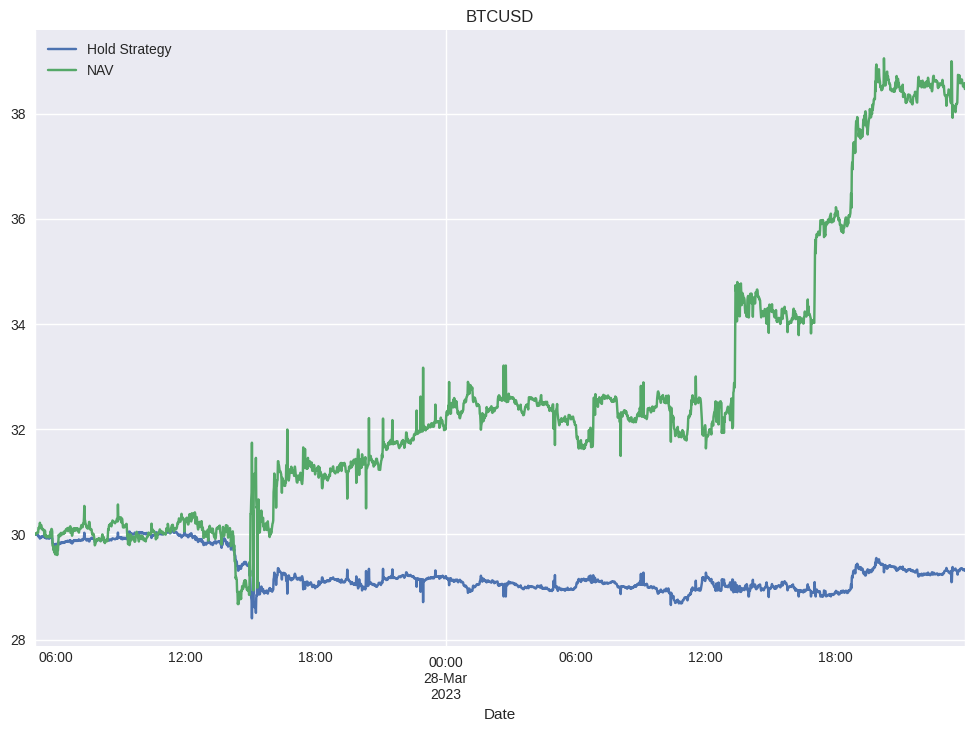

In [175]:
bc.plot_data(["Hold Strategy", "NAV"])

In [104]:
bc.data #with new columns!!

,Open,High,Low,Close,Volume,returns,Hold Strategy,Close|SMA|2,Close|SMA|5,Position,NAV
Date,,,,,,,,,,,
2022-09-11 05:12:00,21574.5,21580.5,21281.1,21577.1,66.892,0.000060,25.025516,21576.45,21566.62,1,24.980008
2022-09-11 05:13:00,21575.8,21580.5,21281.1,21468.9,77.139,-0.005027,24.900024,21523.00,21549.38,-1,24.834868
2022-09-11 05:14:00,21577.1,21580.5,21567.5,21580.5,53.173,0.005185,25.029459,21524.70,21554.24,-1,24.705771
2022-09-11 05:15:00,21580.5,21580.5,21350.0,21350.0,29.071,-0.010738,24.762121,21465.25,21510.46,-1,24.972410
2022-09-11 05:16:00,21494.2,21580.5,21281.1,21569.3,97.245,0.010219,25.016469,21459.65,21509.16,-1,24.718727
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-12 23:55:00,22177.0,22199.0,22052.0,22060.0,205.816,0.000898,25.585592,22050.10,22091.72,0,21.223683
2022-09-12 23:56:00,22198.0,22199.8,22060.0,22199.8,90.778,0.006317,25.747735,22129.90,22123.64,0,21.223683
2022-09-12 23:57:00,22199.8,22199.8,22060.0,22060.0,21.882,-0.006317,25.585592,22129.90,22095.86,0,21.223683


### Testing buying and selling instrument by amount

In [327]:
#put fees false to make calculations simpler
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    start = "2022-09-11", 
    end = "2022-09-12", #take care of the length of period!! It will help to make tests faster 
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/btc-usdt_1m.csv"
)

In [328]:
#prints first period price
bc.data.Close[0]

21555.1

In [329]:
#make the next period double of that to test it easier
bc.data.Close[1] = bc.data.Close[0]*2
bc.data.Close[1]

43110.2

In [330]:
#put the leverage that you want
bc.change_leverage(2)

2

In [331]:
#available balance as declared on bc
bc.available_balance

25

In [332]:
#nav = Net Asset Value. Its the sum of your balance and current position. You dont have positions right now
#must be same as bc.available_balance
bc.get_nav(0)

25

In [333]:
#max amount of money you can spend is your available_balance times leverage
#Important: to spend a certain amount you should do:
#amount_for_function = amount_to_spend*leverage
max_amount = bc.available_balance*bc.leverage
max_amount

50

In [334]:
#buy max amount of units permitted at certain price
bc.submit_order(bar = 0, amount = abs(max_amount), pos = "BUY")

2022-09-11 |  Buying 0.002317782426173874 for 21555.1, leverage 2


In [335]:
#must be 0, because you spent all your money buying units
bc.available_balance

0.0

In [336]:
#opened positions are saved on this array
bc.open_orders

[LONG]

In [337]:
#you can get again the previous bought amount multiplying your units by buy price
# if fees are true, it will be a little less because opening position fee was paid
order = bc.open_orders[0]
amount = order.units*bc.data.Close[0]
amount

49.96003197442047

In [338]:
#nav at time of buy, it must be the same as before buying
#if fee is True it will be less than cell above, because this takes into account the closing position fee
bc.get_nav(0)

24.960031974420467

In [339]:
#nav if we sell at the next period, it must consider leverage profits (and fees)
bc.get_nav(1)

74.90007993605117

In [342]:
#to sell all the units bought using "amount" you need to use defined function
#MUST VERIFY THAT SELLS ALL BOUGHT UNITS
bc.submit_order(bar = 1, amount = bc.current_invested_amount(), pos = "SELL")

2022-09-11 |  Selling (closing) 0.002317782426173874 for 43110.2


In [343]:
#must be same as predicted in bc.get_nav(1)
bc.available_balance

74.90007993605117

In [344]:
#must be same as bc.available_balance (2 cells above) because now you dont have open positions
bc.get_nav(1)

74.90007993605117

In [345]:
#must have now no open orders
bc.open_orders

[]

In [346]:
#closed orders are saved on this array
bc.closed_orders

[LONG]

In [347]:
#you can see the opening paid fee of the order
bc.closed_orders[0].opening_fee_as_amount

0.019984012789768187

In [352]:
#you can see the closing paid fee of the order
#notice this is an array because order can be partially filled, so we pay multiple closing fees
bc.closed_orders[0].closing_fee_as_amount

[0.039968025579536375]

# Using technical indicator classes
We can make a backtest straegy using a technical indicator class, this makes code cleaner. We will use SMA as an example, but you can find all available TIs on Technical Indicators notebook

In [370]:
class SMA():
    
    def __init__(self, data, SMA_S, SMA_L, column, default_strategy = 1, weight = 1):
        self.data = data # Dataframe
        self.weight = weight #weight on the strategy (importance)
        self.SMA_S = column + "|SMA|" + str(SMA_S) # short SMA
        self.SMA_L = column + "|SMA|" + str(SMA_L) # long SMA
        self.short = SMA_S
        self.long = SMA_L
        self.column = column # column to use SMA
        self.default_strategy = default_strategy #strategy to use
        
    def calculate(self, force = False): #calculate for all dataframe
        if not self.SMA_S in self.data.columns or force:
            self.data[self.SMA_S] = self.data[self.column].rolling(self.short).mean()  
        if not self.SMA_L in self.data.columns or force:    
            self.data[self.SMA_L] = self.data[self.column].rolling(self.long).mean()
        #DONT DROP NA BECAUSE OTHER INDICATORS NEED THAT ROWS!!!
    
    def calculate_for_last_row(self): #calculate just for last row
        self.data.loc[self.data.index[-1],self.SMA_S] = self.data[self.column].iloc[-self.short:].rolling(self.short).mean()[-1]
        self.data.loc[self.data.index[-1],self.SMA_L] = self.data[self.column].iloc[-self.long:].rolling(self.long).mean()[-1]
    
    def strategy(self, row, num = -1):
        return self.strategy1(row)
    
    def strategy1(self, row):
        '''Returns predicted position (1,0 or -1)'''
        if self.data[self.SMA_S][row] > self.data[self.SMA_L][row]: # signal to go long
            return 1
        elif self.data[self.SMA_S][row] < self.data[self.SMA_L][row]: # signal to go short
            return -1
        else:
            return 0

In [374]:
class IterativeBacktest(BinanceApi):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.strategies = [] #keeps all the strategies used
        self.predicted_pos = 0 #keeps current predicted position of strategies
        self.ind_sum = 0 #keeps current indicators sum for predicted positions
        self.weights_sum = 0 #keeps weight sum of strategies to use it with leverage
        self.obv = None #stores OBV used to filter trades
        self.lower_bound = 0.001 #Used for rnn strategy and leverage
        self.upper_bound = 0.01
        
    # helper method
    def go_long(self, bar, amount = None, prc = False, go_neutral_first = False):
        if self.get_position() != 0 and go_neutral_first:
            self.go_neutral(bar) #if some position, go neutral first
        self.leverage_strategy(min_x = self.lower_bound, max_x = self.upper_bound)

        if amount == "all":
            amount = self.available_balance * self.leverage
        elif prc: 
            amount = (self.available_balance * amount/100) * self.leverage    
        amount = self.validate_order_amount(amount, self.leverage, bar)
        if amount:
            self.submit_order(bar, amount = amount, pos = "BUY")

    # helper method
    def go_short(self, bar, amount = None, prc = False, go_neutral_first = False):
        if self.get_position() != 0 and go_neutral_first:
            self.go_neutral(bar) #if some position, go neutral first
        self.leverage_strategy(min_x = self.lower_bound, max_x = self.upper_bound)

        if amount == "all":
            amount = self.available_balance * self.leverage
        elif prc: 
            amount = (self.available_balance * amount/100) * self.leverage    
        amount = self.validate_order_amount(amount, self.leverage, bar)
        if amount:
            self.submit_order(bar, amount = amount, pos = "SELL")
    
    def go_neutral(self, bar):
        if self.get_position() == 1: #if long, sell all
            self.submit_order(bar, amount = self.current_invested_amount(), pos = "SELL")
        elif self.get_position() == -1: #if short, buy all
            self.submit_order(bar, amount = self.current_invested_amount(), pos = "BUY")
            
    def calculate_metrics(self, bar):
        if not self.keep_metrics: return
        self.positions.append( self.get_position() )
        self.navs.append( self.get_nav(bar) )
        
    def add_metrics_to_data(self):
        if not self.keep_metrics: return
        self.data["Position"] = self.positions + [0]*( self.data.shape[0] - len(self.positions) )
        self.data["NAV"] = self.navs + [ self.navs[-1] ]*( self.data.shape[0] - len(self.positions) )
        
    def close_final_position(self, bar):
        date, price = self.get_values(bar)
        self.go_neutral(bar) # if some position, go neutral
        perf = (self.available_balance - self.initial_balance) / self.initial_balance * 100
        good_trades = 0
        bad_trades = 0
        good_trades_prc = 0
        bad_trades_prc = 0
        if self.trades > 0 :
            good_trades = np.sum(np.array(self.PnLs) > 0, axis = 0)
            good_trades_prc = round(good_trades / self.trades *100,1)
            bad_trades = np.sum(np.array(self.PnLs) <= 0, axis = 0)
            bad_trades_prc = round(bad_trades / self.trades *100,1)
            
        if self.verbose:
            self.print_available_balance(bar)
            print(75 * "-")
            print("+++ CLOSING FINAL POSITION +++")
            print("net performance (%) = {}".format( round(perf, 2) ))
            print("number of positions opened = {}".format(self.trades)) 
            print("number of liquidated orders = {}".format(self.liquidated_orders))
            print("number of good PnL = {} ({}%)".format(good_trades, good_trades_prc))
            print("number of bad PnL = {} ({}%)".format(bad_trades, bad_trades_prc))
            print("Amount spent on fee = {} ({}% of initial balance)".format(
                self.paid_fees, round(self.paid_fees/self.initial_balance*100, 2))
             ) 
            print(75 * "-")  
    
    def should_end_session(self, bar):
        min_amount_to_invest = self.get_min_amount_to_invest(bar, leverage = self.leverage,just_margin = True)
        #no money and no positions
        if self.available_balance < min_amount_to_invest and self.get_position() == 0:
            if self.verbose:
                print("Not enough money to trade! Ending trading session.")
            return True
        return False
        
    def leverage_strategy(self, min_x, max_x, min_y = 1, max_y = 1):
        if max_y < min_y:
            print("max leverage is less than min leverage")
            return -1
        #y = y1 + m(x-x1) , m =(y2-y1)/(x2-x1)
        #two points of the line: (min_x, min_y) and (max_x, max_y)
        
        x = min(max_x, abs(self.ind_sum)) #short or long, we want just abs number
        m = (max_y-min_y)/(max_x-min_x)
        new_leverage = round( min_y + m*( x - min_x ))
        new_leverage = max(self.get_min_leverage(), new_leverage ) #open orders restrictions
        self.change_leverage(new_leverage)
        return new_leverage
        
        
    def test_sma_strategy(self, SMA_S, SMA_L, leverage = 1,keep_metrics = True, verbose = True):
        self.verbose = verbose 
        if self.verbose:
            stm = "Testing SMA strategy | {} | SMA_S = {} & SMA_L = {}".format(self.symbol, SMA_S, SMA_L)
            print("-" * 75)
            print(stm)
            print("-" * 75)
        
        # reset 
        self.trades = 0  # no trades yet
        self.available_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        self.open_orders = []
        self.closed_orders = []
        self.paid_fees = 0
        self.liquidated_orders = 0
        self.leverage = leverage
        
        # prepare data
        sma = SMA(
            data = self.data,
            SMA_S = SMA_S,
            SMA_L = SMA_L,
            column = "Close"
             )
        sma.calculate() #add columns to data
        
        self.data.dropna(inplace = True) #dropna after calculating the strategy
        
        #prepare metrics
        self.keep_metrics = keep_metrics
        self.positions, self.navs = [], []

        for bar in range(len(self.data)-1): # all bars (except the last bar)
            #date, price = self.get_values(bar) #useful to get current date and price
            self.verify_not_liquidation(bar) #verify current order isnt liquidated
            if self.should_end_session(bar): break #check if should end session  
            ############### Algorithm ############### 
            position = sma.strategy1(bar)
            if position == 1 and self.get_position() in [0, -1]:
                self.go_long(bar, amount = "all", go_neutral_first = True) # go long with full amount
            if position == -1 and self.get_position() in [0, 1]:
                self.go_short(bar, amount = "all", go_neutral_first = True) # go short with full amount
            ############## End Algorithm ############        
            self.calculate_metrics(bar)
            
        self.verify_not_liquidation(bar+1)           
        self.close_final_position(bar+1) # close the final open position
        self.calculate_metrics(bar+1)
        self.add_metrics_to_data()
        return round(self.available_balance, 1)
    
    def optimize_parameters(self, SMA_S_range, SMA_L_range):
        ''' Finds the optimal strategy (global maximum) given the SMA parameter ranges.

        Parameters
        ----------
        SMA_S_range, SMA_L_range: tuple
            tuples of the form (start, end, step size)
        '''
        sma_s_list = np.arange(*SMA_S_range)
        sma_l_list = np.arange(*SMA_L_range)
        combinations = list(product(
            sma_s_list, 
            sma_l_list
        ))
        
        # test all combinations
        results = []
        for comb in combinations:
            results.append(self.test_sma_strategy(
                SMA_S = comb[0], 
                SMA_L = comb[1], 
                leverage = 1, #higher leverage makes tests faster!
                keep_metrics = False, #False makes the process faster
                verbose = False #dont print order stuff
            ))
        
        best_perf = np.max(results) # best performance
        opt = combinations[np.argmax(results)] # optimal parameters
        
        # run/set the optimal strategy
        self.test_sma_strategy(
                SMA_S = opt[0], 
                SMA_L = opt[1], 
                leverage = 1,
                keep_metrics = True, #False makes the process faster
                verbose = False #dont print order stuff
            )
                   
        # create a df with many results
        many_results =  pd.DataFrame(data = combinations, columns = ["SMA_S", "SMA_L"])
        many_results["performance"] = results
        self.results_overview = many_results
                            
        return opt, best_perf  

In [377]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    start = "2022-01-31", 
    end = "2023-06-30",
    amount = 50, 
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004
)

In [378]:
bc.test_sma_strategy(SMA_S = 50, SMA_L = 100, leverage = 20, keep_metrics = False)

---------------------------------------------------------------------------
Testing SMA strategy | BTCUSD | SMA_S = 50 & SMA_L = 100
---------------------------------------------------------------------------
2022-07-12 |  Buying 0.002582946149705493 for 19350.0, leverage 1
2022-07-12 |  Selling (closing) 0.002582946149705493 for 19471.6
2022-07-12 |  Selling 0.0025808806189980115 for 19471.6, leverage 1
2022-07-13 |  Buying (closing) 0.0025808806189980115 for 19500.2
2022-07-13 |  Buying 0.0025712522885343488 for 19500.2, leverage 1
2022-07-13 |  Selling (closing) 0.0025712522885343488 for 19304.6
2022-07-13 |  Selling 0.002569196109175265 for 19304.6, leverage 1
2022-07-13 |  Buying (closing) 0.002569196109175265 for 19729.2
2022-07-13 |  Buying 0.0024566446140261585 for 19729.2, leverage 1
2022-07-14 |  Selling (closing) 0.0024566446140261585 for 19972.9
2022-07-14 |  Selling 0.0024546800841468894 for 19972.9, leverage 1
2022-07-14 |  Buying (closing) 0.0024546800841468894 for 20273

2022-07-27 |  Buying (closing) 0.001491937647506892 for 22207.0
2022-07-27 |  Buying 0.0014339530264518394 for 22207.0, leverage 1
2022-07-27 |  Selling (closing) 0.0014339530264518394 for 21304.0
2022-07-27 |  Selling 0.0014328063227121736 for 21304.0, leverage 1
2022-07-27 |  Buying (closing) 0.0014328063227121736 for 21932.4
2022-07-27 |  Buying 0.0013496215907732158 for 21932.4, leverage 1
2022-07-27 |  Selling (closing) 0.0013496215907732158 for 21904.0
2022-07-27 |  Selling 0.0013485423252068238 for 21904.0, leverage 1
2022-07-27 |  Buying (closing) 0.0013485423252068238 for 22244.0
2022-07-27 |  Buying 0.0013062718948600944 for 22244.0, leverage 1
2022-07-28 |  Selling (closing) 0.0013062718948600944 for 23002.0
2022-07-28 |  Selling 0.0013052272951840768 for 23002.0, leverage 1
2022-07-28 |  Buying (closing) 0.0013052272951840768 for 23244.0
2022-07-28 |  Buying 0.0012770270677262667 for 23244.0, leverage 1
2022-07-29 |  Selling (closing) 0.0012770270677262667 for 23818.5
2022-

22.9

# Optimizing the strategy
You can optimize an strategy trying different values for variables. In this case wi will find the best SMAs with the new function 'optimize_parameters'.

In [383]:
#this way we can make combinations with pairs of params to test them
#np.arange(inf, sup-1, step) makes list with numbers [inf, sup) with a separation "step"
#np.linspace(0, 10, num=4) makes list with numbers [inf, sup] with specified number of elements
#afer making lists, you use product to make all the combinations of all the lists
sma_s_range = np.arange(49, 50+1, 1)
sma_l_range = np.arange(199, 200+1, 1)
combinations = list(  product(  sma_s_range, sma_l_range  )  )
combinations

[(49, 199), (49, 200), (50, 199), (50, 200)]

In [387]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    start = "2022-07-12", 
    end = "2022-07-19", #take care of the length of period!! It will help to make tests faster 
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004
)

In [388]:
bc.optimize_parameters( 
        SMA_S_range = (40,40+2,1), 
        SMA_L_range = (150,150+2,1) 
    )

((41, 151), 24.4)

In [389]:
#Here you can see your results!
bc.results_overview

,SMA_S,SMA_L,performance
0,40,150,21.7
1,40,151,21.8
2,41,150,23.4
3,41,151,24.4


In [35]:
l = [1,3,2,4,5]
sum(elem for elem in l)

15

In [119]:
l = [1,2,3]
for idx in sorted(l, reverse = True):
    continue

In [116]:
l.sorted(reverse=True)
l

AttributeError: 'list' object has no attribute 'sorted'